In [1]:
from pyzls import PyZL

In [2]:
code = """
let node sawtooth(i) = o where
    rec init o = 0
    and automaton
      | Up -> do o = last o + 1 until (o > 10) then Down
      | Down -> do o = last o - 1 until (o < 1) then Up
"""
test = PyZL(code)

In [3]:
t = test.sawtooth()
t.reset()  
[t.step(0) for _ in range(20)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]

In [4]:
print(test.py_code)

from operator import *
from pyzls import Node

class sawtooth(Node):
    def __init__ (self):
        pass
        self.r_21 = False
        self.s_20 = "Tmpv8oz3mve_Down_13"
        self.o_18 = 42
        
    def reset (self, ):
        self.r_21 = False
        self.s_20 = "Tmpv8oz3mve_Up_12"
        self.o_18 = 0
        
    def step (self, i_17):
        l_19 = self.o_18
        if self.s_20 == "Tmpv8oz3mve_Up_12":
            if self.r_21:
                pass
            self.o_18 = add(l_19 , 1)
            if gt(self.o_18 , 10) == True:
                self.r_21 = True
                self.s_20 = "Tmpv8oz3mve_Down_13"
            else:
                self.r_21 = False
        elif self.s_20 == "Tmpv8oz3mve_Down_13":
            if self.r_21:
                pass
            self.o_18 = sub(l_19 , 1)
            if lt(self.o_18 , 1) == True:
                self.r_21 = True
                self.s_20 = "Tmpv8oz3mve_Up_12"
            else:
                self.r_21 = False
   

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

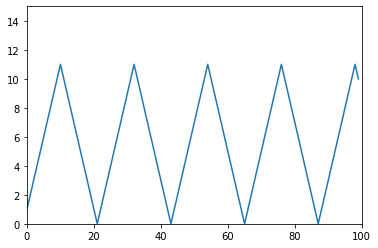

In [9]:
t2 = test.sawtooth()
t2.reset()

n = 100
p = []
for x in range(n):
    clear_output(wait=True)
    p.append(t2.step(0))
    t = [i for i in range(len(p))]
    plt.plot(t , p)
    plt.axis((0 , n , 0 , 15))
    plt.show() 
#     time.sleep(0.01)